## - Wordclouds
## - Determine Sequence Length

In [1]:
import pandas as pd
import numpy as np 
import re
# import string
import wordcloud as wc

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_slow = pd.read_json("./sql-analytics-problem-master/data/slow_log.json")
df_slow.shape #(15688, 12)
# df_slow.head()
# df_slow.info()

(15688, 12)

This function cleans the row query text.

\* is a frequently used punctiotion in sql queries.

Wordcloud does not count punctuation

To keep it in the analysis I replace it with "star"

In [3]:
def customize_text(text):
    text = text.lower()
    text = text.replace('\n', ' ').replace('\r', '')
    text = text.replace('\t', ' ')
    text = text.replace("/*", ' ')
    text = text.replace("2020.2.3", ' ')
    text = text.replace("*/", ' ')
    text = text.replace("*", ' star')
    text = re.sub(r"[',.;@#?!&$=())]+\ *", " ", text)
    text = text.replace("  ", ' ').strip()
    return text

In [4]:
df_sql_text = pd.DataFrame(df_slow["sql_text"].value_counts())
print(f"There are {len(df_sql_text)} unique queries in {len(df_slow)}")

There are 3803 unique queries in 15688


Show a sample for row and cleaned query

In [5]:
i = 20
sql_1 = df_slow["sql_text"][i]
print(sql_1)
print(customize_text(sql_1))

SELECT @@session.transaction_isolation
select session transaction_isolation


Create a column of cleaned query text

In [6]:
df_slow["clean_query"] = df_slow["sql_text"].apply(customize_text)
df_slow["clean_query"]

0        applicationname datagrip   set net_write_timeo...
1                                            show warnings
2                                            show warnings
3               applicationname datagrip   select database
4        applicationname datagrip   set sql_select_limi...
                               ...                        
15683                                             select 1
15684                                             select 1
15685                 select session transaction_isolation
15686                                        show warnings
15687    applicationname datagrip   select star from my...
Name: clean_query, Length: 15688, dtype: object

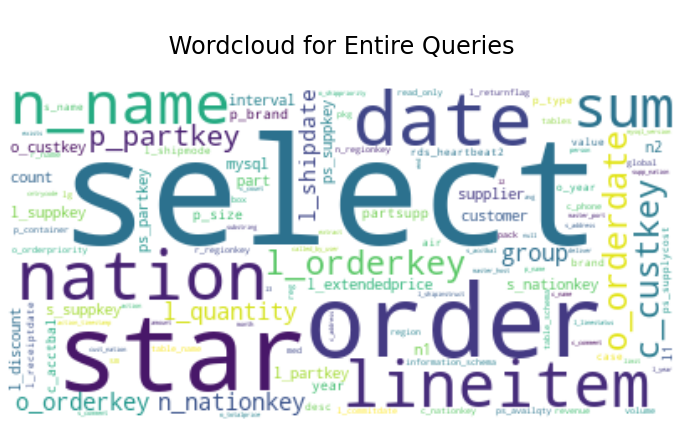

In [7]:
corpus = ' '.join((df_slow["clean_query"]))

fig = plt.figure(figsize=(12, 18))
sql_wordcloud = wc.WordCloud(background_color="white",
                                collocations=False,
                                ).generate(corpus)
plt.imshow(sql_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("\n Wordcloud for Entire Queries \n", fontsize=24)
plt.show()

In [8]:
def get_freq(corpus):
    text_dictionary = sql_wordcloud.process_text(corpus)
    word_freq={k: v for k, v in sorted(text_dictionary.items(),reverse=True, key=lambda item: item[1])}
    df_freq = pd.DataFrame(index = word_freq.keys(), data=word_freq.values()).reset_index()
    df_freq.columns = ["Token", "Frequency"]
    df_freq["Perc_Frequency"] = df_freq.Frequency / np.sum(df_freq.Frequency) 
    return df_freq
# df_freq.Frequency[i] / df_freq.Frequency.sum()
df_freq_corpus = get_freq(corpus)
df_freq_corpus[:10]

,Token,Frequency,Perc_Frequency
0,select,19462,0.077952
1,star,7737,0.030989
2,order,6918,0.027709
3,date,6300,0.025234
4,nation,5250,0.021028
5,lineitem,5250,0.021028
6,n_name,4800,0.019226
7,sum,4350,0.017423
8,l_orderkey,4350,0.017423
9,o_orderdate,4200,0.016822


In [9]:
t_day = df_slow["query_time"][0]
t_day = pd.to_datetime(t_day.strftime('%Y-%m-%d'))

# t2 = pd.to_datetime("2021-05-10")
df_slow["query_time_ns"] = (df_slow["query_time"]
                            .apply(lambda x: (x - t_day).total_seconds()*1000000)
                            )
#%
summary = df_slow["query_time_ns"]\
    .describe(percentiles=[0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99, 1.00])


Create another wordcloud for extremely high query times

In [10]:
mask = (df_slow["query_time_ns"]>summary["99%"])
s =summary["99%"]
print(f"{sum(mask)} of the queries are higher than {s:.2f}")

157 of the queries are higher than 4166627.23


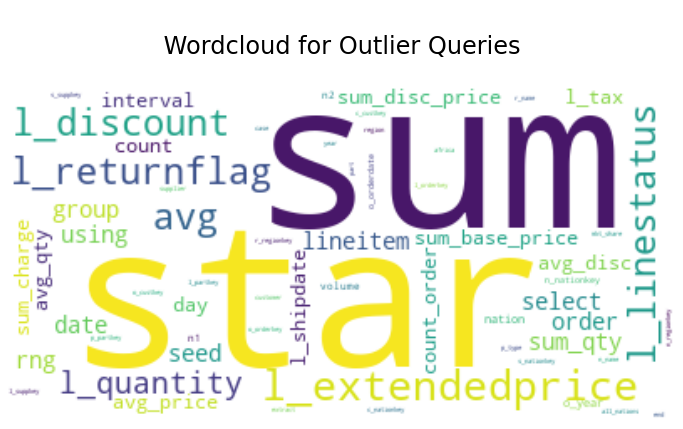

In [11]:
outlier_corpus = ' '.join((df_slow.loc[mask, "clean_query"]))
type(outlier_corpus)
fig = plt.figure(figsize=(12, 18))
sql_wordcloud = wc.WordCloud(background_color="white",
                                collocations=False,
                                ).generate(outlier_corpus)
plt.imshow(sql_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("\n Wordcloud for Outlier Queries \n", fontsize=24)
plt.show()

In [12]:
df_freq_outlier = get_freq(outlier_corpus)
df_freq_outlier[:10]

,Token,Frequency,Perc_Frequency
0,sum,610,0.082288
1,star,608,0.082018
2,l_extendedprice,606,0.081748
3,l_discount,456,0.061514
4,l_returnflag,450,0.060704
5,l_linestatus,450,0.060704
6,avg,450,0.060704
7,l_quantity,301,0.040604
8,select,162,0.021854
9,order,162,0.021854


In [13]:
last = df_slow["start_time"].max()
first = df_slow["start_time"].min()
t1 = pd.to_datetime("2021-01-14 11:27:00")
t2 = pd.to_datetime("2021-01-14 12:27:00")
t3 = pd.to_datetime("2021-01-14 13:00:00")
t4 = pd.to_datetime("2021-01-14 14:27:00")

Create another wordcloud for intensive periods

In [14]:
mask = ((df_slow.start_time>t1) & (df_slow.start_time<t2)) | ((df_slow.start_time>t3) & (df_slow.start_time<t4))
print(sum(mask))
# mask

12235


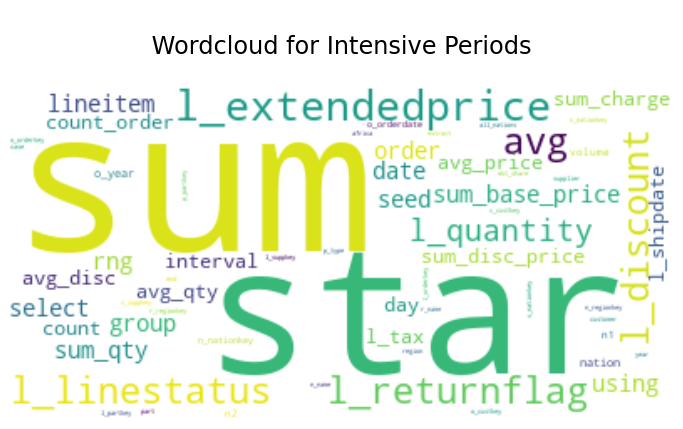

In [15]:
intensive_corpus = ' '.join((df_slow.loc[mask, "clean_query"]))
fig = plt.figure(figsize=(12, 18))
sql_wordcloud = wc.WordCloud(background_color="white",
                                collocations=False,
                                ).generate(outlier_corpus)
plt.imshow(sql_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("\n Wordcloud for Intensive Periods \n", fontsize=24)
plt.show()

In [16]:
df_freq_intensive = get_freq(intensive_corpus)
df_freq_intensive[:10]

,Token,Frequency,Perc_Frequency
0,select,16194,0.068173
1,star,7211,0.030357
2,order,6745,0.028395
3,date,6300,0.026522
4,nation,5250,0.022101
5,lineitem,5250,0.022101
6,n_name,4800,0.020207
7,sum,4350,0.018313
8,l_orderkey,4350,0.018313
9,o_orderdate,4200,0.017681


Create another wordcloud for non-intensive periods

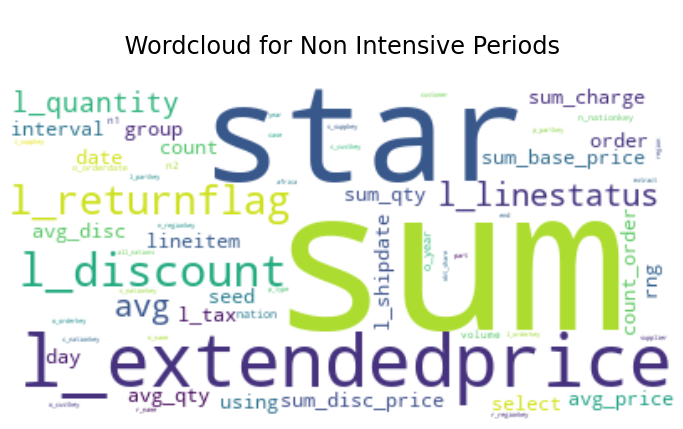

In [17]:
non_intensive_corpus = ' '.join((df_slow.loc[~mask, "clean_query"]))
fig = plt.figure(figsize=(12, 18))
sql_wordcloud = wc.WordCloud(background_color="white",
                                collocations=False,
                                ).generate(outlier_corpus)
plt.imshow(sql_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("\n Wordcloud for Non Intensive Periods \n", fontsize=24)
plt.show()


In [18]:
df_freq_non_intensive = get_freq(non_intensive_corpus)
df_freq_non_intensive[:10]

,Token,Frequency,Perc_Frequency
0,select,3268,0.269504
1,mysql,896,0.073891
2,rds_heartbeat2,704,0.058057
3,star,526,0.043378
4,count,521,0.042966
5,value,400,0.032987
6,global,352,0.029029
7,information_schema,352,0.029029
8,tables,352,0.029029
9,table_schema,352,0.029029


### Compare token frequencies in different periods

In [19]:
df_compare = pd.concat([df_freq_corpus, df_freq_outlier, df_freq_intensive, df_freq_non_intensive], axis=1)[:10]["Token"]
df_compare.columns = ["All", "Outlier", "Intense", "NonIntense"]
df_compare

,All,Outlier,Intense,NonIntense
0,select,sum,select,select
1,star,star,star,mysql
2,order,l_extendedprice,order,rds_heartbeat2
3,date,l_discount,date,star
4,nation,l_returnflag,nation,count
5,lineitem,l_linestatus,lineitem,value
6,n_name,avg,n_name,global
7,sum,l_quantity,sum,information_schema
8,l_orderkey,select,l_orderkey,tables
9,o_orderdate,order,o_orderdate,table_schema


## In deep learning models, we need to determine the sequence length to feed into the model.


In [20]:
df_slow["query_len"] = df_slow["clean_query"].apply(lambda x: len(x.split(" ")))

df_slow[["clean_query","query_len"]] 

,clean_query,query_len
0,applicationname datagrip set net_write_timeo...,7
1,show warnings,2
2,show warnings,2
3,applicationname datagrip select database,6
4,applicationname datagrip set sql_select_limi...,7
...,...,...
15683,select 1,2
15684,select 1,2
15685,select session transaction_isolation,3
15686,show warnings,2


Below analysis shows that 128 is a good value as sequence length
HuggingFace documentation recommends power of 2 number of sequence length


In [21]:
summary_quey_len = df_slow["query_len"]\
    .describe(percentiles=[0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99, 1.00])
max_point = df_slow["query_len"].max()
print(summary_quey_len["95%"])

105.0


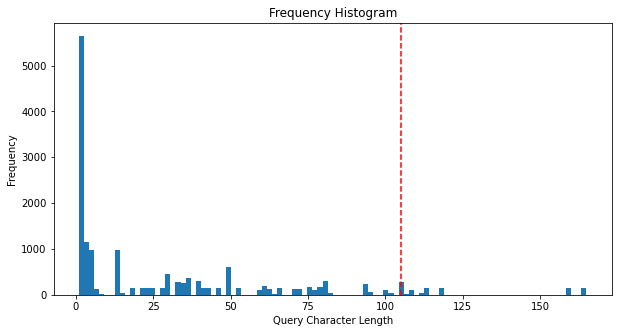

In [22]:
fig, ax = plt.subplots(figsize=(10,5))
ax.hist(df_slow["query_len"], bins=100)
ax.set_xlabel("Query Character Length")
ax.set_ylabel("Frequency")
ax.set_title('Frequency Histogram')
ax.axvline(x=summary_quey_len["95%"], c="r", linestyle="--")
plt.show()

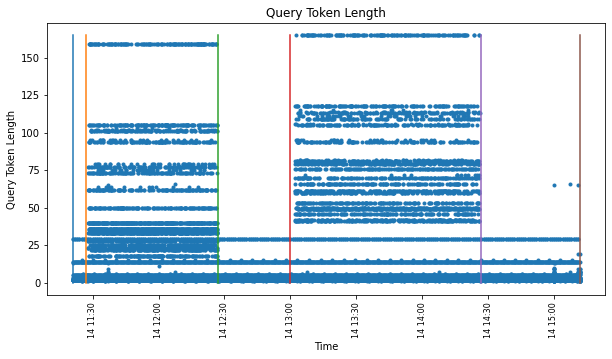

In [23]:
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(df_slow.start_time.values, 
            df_slow.query_len.values, 
            marker= ".")
ax.set_ylabel("Query Token Length")
ax.set_xlabel("Time")
ax.set_title("Query Token Length")
plt.xticks(rotation =90, fontsize=8)

ax.plot([first, first], [0, max_point])
ax.plot([t1, t1], [0, max_point])
ax.plot([t2, t2], [0, max_point])
ax.plot([t3, t3], [0, max_point])
ax.plot([t4, t4], [0, max_point])
ax.plot([last, last], [0, max_point])

plt.show(fig)